In [1]:
import argparse
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pycocotools.coco import COCO

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate
from detectron2.evaluation import inference_on_dataset
from detectron2.checkpoint import DetectionCheckpointer

from yolof_mask.modeling.box_ops import box_iou
from yolof_mask.utils.general import ap_per_class
from yolof_mask.data import register_bdd100k_coco_format_instances

In [2]:
config_path = '/home/giakhang/dev/YOLOF-Mask/configs/InstanceSegmentation/yolof_mask_RegNetX_4gf_SAM_3x.py'
model_weight = '/home/giakhang/Downloads/model_best.pth'

cfg = LazyConfig.load(config_path)

/home/giakhang/dev/albumentations/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
d_name = 'bdd100k_val'
img_phase_dir = '/home/giakhang/dev/YOLOF-Mask/datasets/bdd100k/images/10k/val'
annot_phase_path = '/home/giakhang/dev/YOLOF-Mask/datasets/bdd100k/labels_coco/ins_seg/ins_seg_val_coco.json'

register_bdd100k_coco_format_instances(
    d_name, 
    {},
    annot_phase_path,
    img_phase_dir
)

coco = COCO(annot_phase_path)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [4]:
categories = {coco.loadCats(cat_id)[0]['id'] : coco.loadCats(cat_id)[0]['name']
              for cat_id in coco.getCatIds()}

traffic_objects = ['car', 'bus', 'truck', 'train']

In [5]:
cfg.dataloader.evaluator.dataset_name = f"bdd100k_val"
cfg.dataloader.test.dataset.names = f"bdd100k_val"
cfg.dataloader.test.batch_size = 1

cfg.model.decoder.num_classes = len(traffic_objects)
cfg.model.mask_head.num_classes = len(traffic_objects)

In [6]:
model = instantiate(cfg.model)
model.to(cfg.train.device)
model.eval()
DetectionCheckpointer(model).load(model_weight)

None
[05/17 10:53:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/giakhang/Downloads/model_best.pth ...


Skip loading parameter 'decoder.cls_score.weight' to the model due to incompatible shapes: (40, 512, 3, 3) in the checkpoint but (20, 512, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'decoder.cls_score.bias' to the model due to incompatible shapes: (40,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'mask_head.predictor.weight' to the model due to incompatible shapes: (8, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'mask_head.predictor.bias' to the model due to incompatible shapes: (8,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
decoder.cls_score.{bias, weight}
mask_head.predictor.{bias, weight}


{'trainer': {'iteration': 407999,
  'hooks': {'LRScheduler': {'base_lrs': [0.01], 'last_epoch': 408000}},
  'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[ 4.9461e-04]],
     
              [[ 2.1961e-04]],
     
              [[-1.3590e-04]],
     
              ...,
     
              [[ 1.3418e-04]],
     
              [[ 3.9283e-04]],
     
              [[ 8.9858e-04]]],
     
     
             [[[ 3.4967e-04]],
     
              [[ 3.4954e-04]],
     
              [[ 1.3297e-03]],
     
              ...,
     
              [[ 6.1552e-04]],
     
              [[ 1.3317e-03]],
     
              [[ 3.2715e-04]]],
     
     
             [[[-1.7426e-04]],
     
              [[-2.6692e-04]],
     
              [[-3.1359e-06]],
     
              ...,
     
              [[ 8.3790e-05]],
     
              [[ 7.6537e-05]],
     
              [[-7.2681e-05]]],
     
     
             ...,
     
     
             [[[ 2.8892e-04]],
     
              [[-7.24

In [7]:
dataloader = instantiate(cfg.dataloader.test)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



/home/giakhang/dev/YOLOF-Mask/datasets/bdd100k/labels_coco/ins_seg/ins_seg_val_coco.json contains 13011 annotations, but only 11643 of them match to images in the file.


cats:  [{'id': 3, 'name': 'car'}, {'id': 4, 'name': 'truck'}, {'id': 5, 'name': 'bus'}, {'id': 6, 'name': 'train'}]
cat_ids:  [3, 4, 5, 6]
ting_classes:  ['car', 'truck', 'bus', 'train']
contiguous id_map:  {3: 0, 4: 1, 5: 2, 6: 3}
[05/17 11:17:42 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    car     | 10889        |   truck    | 521          |    bus     | 219          |
|   train    | 7            |            |              |            |              |
|   total    | 11636        |            |              |            |              |
[05/17 11:17:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333)]
[05/17 11:17:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._Torc

In [33]:
metadata = MetadataCatalog.get(d_name)
dis_cls = list(metadata.thing_dataset_id_to_contiguous_id.keys())
contiguous_id = list(metadata.thing_dataset_id_to_contiguous_id.values())

def load_gt_annot_by_img_id(img_id):
    annot = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    boxes_xywh = []
    gt_cls = []

    for a in annot:
        if a['category_id'] not in dis_cls:
            continue
        boxes_xywh.append(a['bbox'])
        dis_cls_id = dis_cls.index(a['category_id'])
        gt_cls.append(contiguous_id[dis_cls_id])

    boxes_xywh = np.array(boxes_xywh)
    gt_cls = np.array(gt_cls)

    gt_bboxes = np.zeros_like(boxes_xywh)
    if boxes_xywh.shape[0] == 0:
        return gt_cls, gt_bboxes

    gt_bboxes[:, 0] = boxes_xywh[:, 0]
    gt_bboxes[:, 1] = boxes_xywh[:, 1]
    gt_bboxes[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]
    gt_bboxes[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]

    gt_bboxes = gt_bboxes.astype(np.int32)
    
    return gt_cls, gt_bboxes

In [9]:
stats = []

for idx, inputs in tqdm(enumerate(dataloader), total=len(dataloader)):
    assert 1 == 2
    outputs = model(inputs)
    outputs = outputs[0]

    img_id = inputs[0]['image_id']
    tcls, tbox = load_gt_annot_by_img_id(img_id)
    tcls_tensor = torch.tensor(tcls)
    tbox = torch.tensor(tbox, dtype=torch.float32)

    iouv = torch.linspace(0.5,0.95,10)    #iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    correct = torch.zeros(outputs['instances'].pred_boxes.tensor.shape[0], niou, dtype=torch.bool)

    nl = len(tcls)

    if len(outputs['instances'].pred_boxes.tensor) == 0:
        if nl:
            stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
        continue

    pred_cls = outputs['instances'].pred_classes.cpu()
    pred_boxes = outputs['instances'].pred_boxes.tensor.detach().cpu()
    pred_scores = outputs['instances'].scores.detach().cpu().numpy()

    #if nl:
    detected = []  # target indices
    # Per target class
    for cls_id in torch.unique(tcls_tensor):                    
        ti = (cls_id == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
        pi = (cls_id == pred_cls).nonzero(as_tuple=False).view(-1)  # target indices

        # Search for detections
        if pi.shape[0]:
            # Prediction to target ious
            # n*m  n:pred  m:label
            ious, i = box_iou(pred_boxes[pi], tbox[ti])[0].max(1)  # best ious, indices
            # Append detections
            detected_set = set()
            for j in (ious > iouv[0]).nonzero(as_tuple=False):
                d = ti[i[j]]  # detected target
                if d.item() not in detected_set:
                    detected_set.add(d.item())
                    detected.append(d)
                    correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                    if len(detected) == nl:  # all targets already located in image
                        break

    stats.append((correct, pred_scores, pred_cls, tcls))

  0%|          | 0/1000 [00:00<?, ?it/s]


AssertionError: 

In [ ]:
stats = [np.concatenate(x, 0) for x in zip(*stats)]

In [ ]:
p, r, ap, f1, ap_class = ap_per_class(*stats, plot=False)
ap50, ap70, ap75,ap = ap[:, 0], ap[:,4], ap[:,5], ap.mean(1)  # [P, R, AP@0.5, AP@0.5:0.95]
mp, mr, map50, map70, map75, map = p.mean(), r.mean(), ap50.mean(), ap70.mean(), ap75.mean(), ap.mean()

In [ ]:
map50

0.3932264314162161

In [ ]:
ap50

array([0.55007387, 0.40382149, 0.65513954, 0.41146225, 0.38958707,
       0.00241667, 0.49937075, 0.23393981])

In [ ]:
traffic_objects_map50 = []
traffic_objects_recall = []

for cls_id in ap_class:
    dis_cls_id = dis_cls[contiguous_id.index(cls_id)]
    if categories[dis_cls_id] in traffic_objects:
        traffic_objects_map50.append(ap50[cls_id])
        traffic_objects_recall.append(r[cls_id])

traffic_objects_map50 = np.array(traffic_objects_map50)
traffic_objects_recall = np.array(traffic_objects_recall)

print('traffic object mAP50:', traffic_objects_map50.mean())
print('traffic_object recall: ', traffic_objects_recall.mean())

traffic object mAP50: 0.48539628671183865
traffic_object recall:  0.5908498652700103


In [ ]:
img_path = inputs[0]['file_name']
img = np.ascontiguousarray(cv2.imread(img_path)[..., ::-1])

bboxes = pred_boxes.numpy().astype(np.int32)
gt_bboxes = tbox.numpy().astype(np.int32) 

for bbox in bboxes:
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

for gt_box in gt_bboxes:
    cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 0, 0), 2)

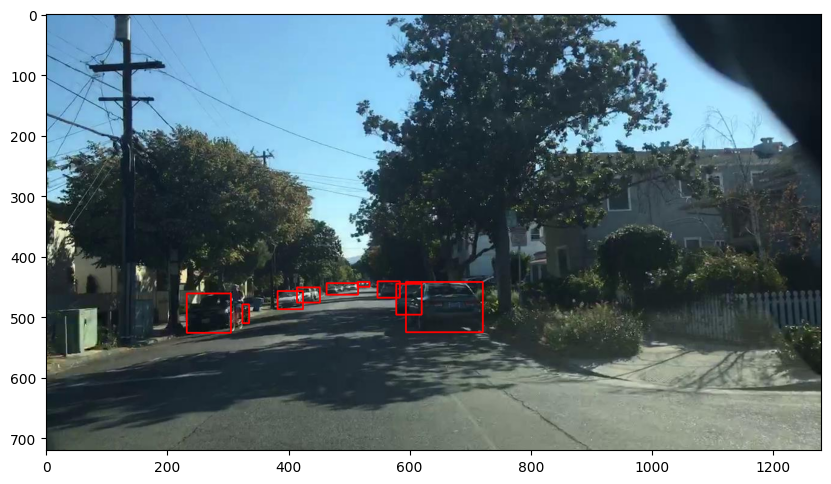

In [48]:
_ = plt.figure(figsize=(10, 10))

plt.imshow(img)